In [2]:
"""
Demonstrating basic usage of Kinect2 cameras.
"""
from libkinect2.utils import draw_skeleton, depth_map_to_image, ir_to_image
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import h5py
import time

from libkinect2.utils import depth_map_to_image
# frame rate (e.g., 10 frames per second)
desired_frame_rate = 5
frame_delay = 1.0 / desired_frame_rate
farthresh = 10

class Hdf5_Dataset():
    def __init__(self, io_file=None, hf_handler=None, readmode=False):
        """
        Either the output_file or the hf_handler need to be provided,
        if both are provided hf_handler is ignored.
        """
        self.readmode = readmode
        if self.readmode:
            self.hf_handler = h5py.File(io_file, "r")
        else:
            if io_file is not None:
                if os.path.exists(io_file):
                    self.hf_handler = h5py.File(io_file, "a")
                else:
                    self.hf_handler = h5py.File(io_file, "w")
            elif hf_handler is not None:
                self.hf_handler = hf_handler

    def get_frames(self, dtname):
        if not self.readmode:
            raise Exception("Datasets can only be read when readmode = True!")
        return self.hf_handler[dtname][:]

    def init_dataset(self, dtname, sample):
        if self.readmode:
            raise Exception("Can't create datasets in readmode!")
        self.hf_handler.create_dataset(
                dtname, (1, *sample.shape), maxshape=(None, *sample.shape),
                chunks=True)

    def append_sample(self, dtname, sample):
        if self.readmode:
            raise Exception("Can't create datasets in readmode!")
        if dtname not in self.hf_handler:
            self.init_dataset(dtname, sample)
            print(f"Appending to inexistent dataset: {dtname}. Created.")
        self.hf_handler[dtname].resize(
            (self.hf_handler[dtname].shape[0] + 1, ) + sample.shape)

    def __enter__(self):
        pass
        return self
    
    def __exit__(self, exception_type, exception_value, exception_traceback):
        self.hf_handler.close()

        
input_file = r"C:\Users\NTUG3\Documents\LibKinect2\frames_box.h5"


with Hdf5_Dataset(input_file, readmode=True) as hf:
    color_imgs = hf.get_frames("rgb")
    depth_maps = hf.get_frames("depth")
    ir_datas = hf.get_frames("ir")
    frame_index = 0
    start_time = time.time()
    next_frame_time = start_time + frame_delay
    frames = zip(color_imgs, depth_maps, ir_datas)
    bg_img, depth_map, ir_img = next(frames)


In [48]:
framenum = 18
depth_maps[framenum].max()

7919.0

In [49]:
depth_maps[0].shape

(424, 512, 1)

In [50]:
depth_maps.shape

(101, 424, 512, 1)

0.0 7919.0


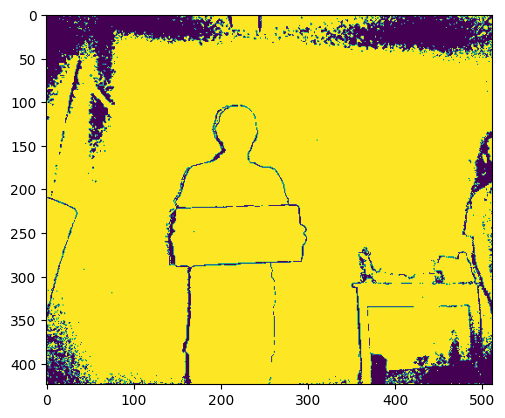

In [53]:
print(depth_maps[framenum].min(), depth_maps[framenum].max())
plt.imshow(depth_maps[framenum] > 0)

In [59]:
closest.shape

(190166,)

In [66]:
depth_maps.shape[1:]

(424, 512, 1)

In [94]:
depth_map.shape

(424, 512, 1)

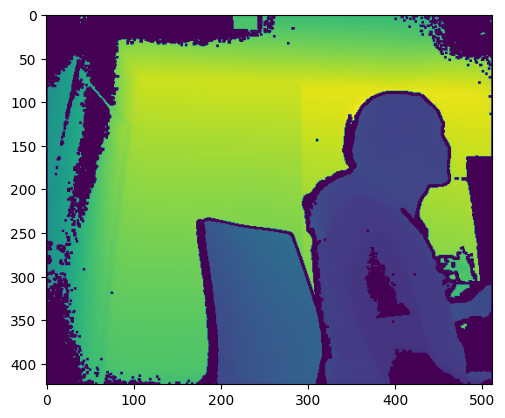

In [95]:
from skimage import morphology
sq = morphology.square(width=3)
x = morphology.erosion(depth_map[:,:,0], sq)
plt.imshow(x)

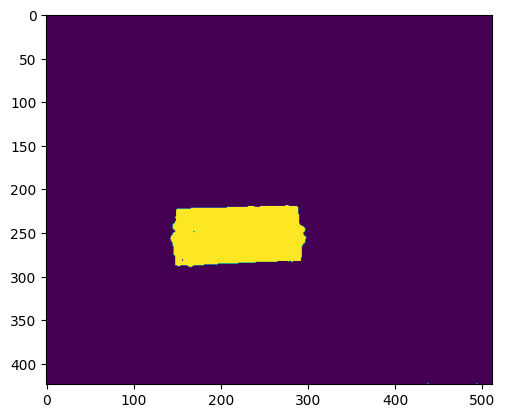

In [70]:
r = 500
m = 200
depth_maps[framenum][:,:100,:] = 0
closest = depth_maps[framenum][depth_maps[framenum]>r].min()
box_mask = (depth_maps[framenum] > closest) & (depth_maps[framenum] < closest+m)
plt.imshow(box_mask)

In [71]:
box_mask = box_mask.astype('uint8')*255



In [72]:
contours, _ = cv2.findContours(box_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
convex_hull_image = np.zeros_like(box_mask)

for contour in contours:
    convex_hull = cv2.convexHull(contour)
    
    # Draw the convex hull on the empty image
    cv2.drawContours(convex_hull_image, [convex_hull], 0, 255, -1)

#plt.imshow('Grayscale Image', box_mask)


In [89]:
minx = convex_hull.squeeze()[:,0].min()
maxx = convex_hull.squeeze()[:,0].max()
dx = maxx-minx
miny = convex_hull.squeeze()[:,1].min()
maxy = convex_hull.squeeze()[:,1].max()
dy = maxy-miny
area = (maxx-minx)*(maxy-miny)
mean_dist = depth_maps[framenum][box_mask>1].mean()
print(dx)
print(dy)
print(area)
print(mean_dist) # Kinect gives points in mm ref: https://stackoverflow.com/a/9678900/3562468

155
70
10850
912.49146


In [91]:
# Known parameters
# REF: https://stackoverflow.com/a/45481222/3562468
box_cm = 35 # Referencial
focal_length = 400# 365.7 # Ref: https://www.semanticscholar.org/paper/Calibration-of-Kinect-for-Xbox-One-and-Comparison-Pagliari-Pinto/6efdd37a71f4cd3a7a0c82c89eabcbb223a11ea3
horizontal_fov_deg = 70.6  
depth_map_width = 512  

# Calculate degrees per pixel in the horizontal direction
degrees_per_pixel_horizontal = horizontal_fov_deg / depth_map_width

# Calculate object width in pixels based on known width
px_to_cm = dx *((mean_dist/10)/focal_length)  # 

print(f"The object's width in pixels is approximately {px_to_cm:.2f} cm.")


The object's width in pixels is approximately 35.36 cm.


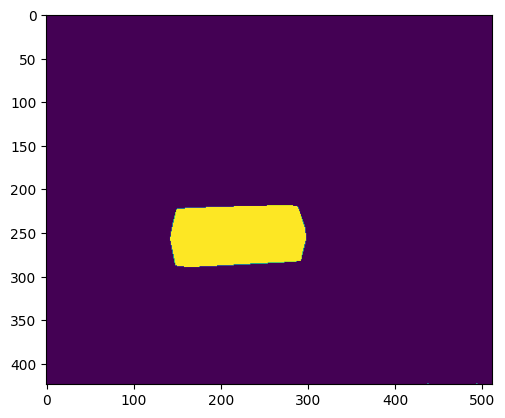

In [76]:
plt.imshow(convex_hull_image)

In [13]:
    closest = depth_map.min()
    print(f"Closest: {closest}")
    rect_size = 10
    tp = depth_map.shape[1]//2-rect_size
    bt = depth_map.shape[1]//2+rect_size
    lf = depth_map.shape[0]//2-rect_size
    rt = depth_map.shape[0]//2+rect_size
    
    small_rect = depth_map[tp:bt, lf:rt]
    depth_img = depth_map < closest+farthresh
    print(f"rect - min depth: {small_rect.min()} max depth {small_rect.max()}")

    depth_img = depth_img.astype('uint8')*255
    ir_img = ir_to_image(ir_data)

    depth_img[tp:bt  , lf:lf+1] = 255 # Left
    depth_img[tp:bt  , rt-1:rt] = 255 # Right
    depth_img[tp:tp+1, lf:rt] = 255 # Top
    depth_img[bt-1:bt,lf:rt] = 255 # Bottom


    # Resizing to present in screen
    ir_img = cv2.resize(ir_img, (ir_img.shape[1]//2,ir_img.shape[0]//2))
    bg_img = cv2.resize(color_img, (color_img.shape[1]//2,color_img.shape[0]//2))
    depth_img = cv2.resize(depth_img, (depth_img.shape[1]//2,depth_img.shape[0]//2))

    bg_img[:depth_img.shape[0],:depth_img.shape[1], :] = np.dstack([depth_img]*3)
    bg_img[-ir_img.shape[0]:,:ir_img.shape[1], :] = ir_img

    # Draw simple skeletons
    #body_img = np.zeros(color_img.shape)
    #for body in bodies:
    #    draw_skeleton(body_img, body)
    #bg_img[:424, -512:, :] = cv2.resize(body_img, (512, 424))
    
    cv2.imshow('sensors', bg_img)


    key = cv2.waitKey(1) & 0xFF
    if key == ord('q'):
        break

kinect.disconnect()

Closest: 0.0
rect - min depth: 947.0 max depth 1089.0


NameError: name 'ir_data' is not defined